In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pylab as pl
import os

In [4]:
# sklearn imports
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

# skopt imports
from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV

# distributions we'll need
from scipy.stats import uniform, loguniform

In [5]:
# skopt imports
from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV

# distributions we'll need
from scipy.stats import uniform, loguniform

In [39]:
df = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [7]:
sample = df.sample(frac = .2, random_state = 42)
sample['label'].value_counts()

2    1224
4    1221
7    1219
1    1218
9    1214
5    1188
8    1186
3    1184
0    1177
6    1169
Name: label, dtype: int64

In [8]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df['label'].value_counts()

0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: label, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 359.3 MB


## Modeling

In [11]:
X = df.drop(columns = ['label'])
y = df['label']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

## Ridge

In [13]:
logreg = LogisticRegression(penalty = 'none', random_state = 42, verbose = 1)

In [14]:
%%time
logreg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 24.3 s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.9s finished


LogisticRegression(penalty='none', random_state=42, verbose=1)

In [15]:
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.9838888888888889, 0.9630666666666666)

### Sample creation

In [16]:
X = sample.drop(columns = ['label'])
y = sample['label']

Xs_train, Xs_test, ys_train, ys_test = train_test_split(X, y, random_state = 42, stratify = y)

## Lasso

In [17]:
lasso_pipe = Pipeline([
    ('ss', StandardScaler(with_mean = False)),
    ('lasso', LogisticRegression(random_state = 42))
])

lasso_params = {
    'lasso__C': np.logspace(-3, 0, 10)
}

lassoRS = RandomizedSearchCV(estimator = lasso_pipe,
                     param_distributions = lasso_params,
                     scoring = 'accuracy',
                     n_iter = 5,
                     n_jobs = -2,
                     cv = 5,
                     verbose = 1)

In [18]:
%%time
lassoRS.fit(Xs_train, ys_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Wall time: 32 s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ss',
                                              StandardScaler(with_mean=False)),
                                             ('lasso',
                                              LogisticRegression(random_state=42))]),
                   n_iter=5, n_jobs=-2,
                   param_distributions={'lasso__C': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])},
                   scoring='accuracy', verbose=1)

In [19]:
lassoRS.score(Xs_train, ys_train), lassoRS.score(Xs_test, ys_test)

(0.9891111111111112, 0.9606666666666667)

## SVM

In [20]:
svc = SVC(gamma="scale")
svc.fit(X_train, y_train)

SVC()

In [26]:
%%time
svc.score(X_train, y_train), svc.score(X_test, y_test)

Wall time: 7min 56s


(0.9939777777777777, 0.9878)

In [ ]:
%%time
svc.score(Xs_train, ys_train), svc.score(Xs_test, ys_test)

In [ ]:
%%time
svcCV.fit(Xs_train, ys_train)

In [32]:
ypred = svc.predict(X_test)
accuracy_score(y_test, ypred)

0.9878

In [24]:
svc_pipe = Pipeline([
    ('svc', SVC(random_state = 42) )
])

svc_params = {
    'svc__C': np.logspace(0,100,10),
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid', 'precomputed'],
    'svc__gamma': ['scale', 'auto']

}

svcCV = RandomizedSearchCV(estimator = svc_pipe,
                     param_distributions = svc_params,
                     scoring = 'accuracy',
                     n_iter = 2,
                     n_jobs = -2,
                     cv = 5,
                     verbose = 1)

In [25]:
%%time
svcCV.fit(Xs_train, ys_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 39 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('svc', SVC(random_state=42))]),
                   n_iter=2, n_jobs=-2,
                   param_distributions={'svc__C': array([1.00000000e+000, 1.29154967e+011, 1.66810054e+022, 2.15443469e+033,
       2.78255940e+044, 3.59381366e+055, 4.64158883e+066, 5.99484250e+077,
       7.74263683e+088, 1.00000000e+100]),
                                        'svc__gamma': ['scale', 'auto'],
                                        'svc__kernel': ['linear', 'rbf', 'poly',
                                                        'sigmoid',
                                                        'precomputed']},
                   scoring='accuracy', verbose=1)

In [56]:
svcCV.score(Xs_train, ys_train), svcCV.score(Xs_test, ys_test)

(1.0, 0.9823333333333333)

In [47]:
svcCV.best_params_

{'svc__kernel': 'rbf', 'svc__gamma': 'scale', 'svc__C': 1.6681005372000558e+22}

In [34]:
svc2_pipe = Pipeline([
    ('svc', SVC(kernel = 'rbf', gamma = 'scale', random_state = 42) )
])

svc2_params = {
    'svc__C': np.logspace(0,100,20),

}

svc2CV = RandomizedSearchCV(estimator = svc2_pipe,
                     param_distributions = svc2_params,
                     scoring = 'accuracy',
                     n_iter = 2,
                     n_jobs = -2,
                     cv = 5,
                     verbose = 1)

In [35]:
svc2CV.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('svc', SVC(random_state=42))]),
                   n_iter=2, n_jobs=-2,
                   param_distributions={'svc__C': array([1.00000000e+000, 1.83298071e+005, 3.35981829e+010, 6.15848211e+015,
       1.12883789e+021, 2.06913808e+026, 3.79269019e+031, 6.95192796e+036,
       1.27427499e+042, 2.33572147e+047, 4.28133240e+052, 7.84759970e+057,
       1.43844989e+063, 2.63665090e+068, 4.83293024e+073, 8.85866790e+078,
       1.62377674e+084, 2.97635144e+089, 5.45559478e+094, 1.00000000e+100])},
                   scoring='accuracy', verbose=1)

In [36]:
svc2CV.best_params_

{'svc__C': 1.623776739188744e+84}

In [38]:
svc2CV.score(X_train, y_train), svc2CV.score(X_test, y_test)

(1.0, 0.9900666666666667)

## Multinomial Naive Bayes

In [27]:
nb_pipe = Pipeline([
    ('nb', MultinomialNB() )
])

nb_params = {

}

naiveb = RandomizedSearchCV(estimator = nb_pipe,
                     param_distributions = nb_params,
                     scoring = 'accuracy',
                     n_iter = 2000,
                     n_jobs = -2,
                     cv = 5,
                     verbose = 1)

In [28]:
naiveb.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=2000. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(cv=5, estimator=Pipeline(steps=[('nb', MultinomialNB())]),
                   n_iter=2000, n_jobs=-2, param_distributions={},
                   scoring='accuracy', verbose=1)

In [29]:
naiveb.score(X_train, y_train),naiveb.score(X_test, y_test)

(0.9067333333333333, 0.907)

# Test Data csv

In [40]:
test.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
X_test_csv = test.drop(columns = ['id'])
test_preds = svc2CV.predict(X_test_csv)

output = {'id':test['id'], 'predictions':test_preds}

In [44]:
output = pd.DataFrame(output)

In [46]:
output.to_csv('./submission.csv', index = False)

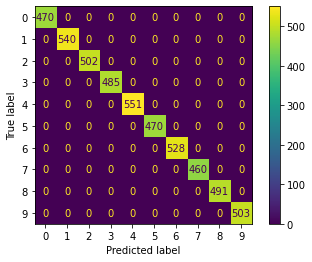

In [48]:
plot_confusion_matrix(svc2CV, X_test_csv, test_preds)